## 1. Install Dependencies

In [55]:
!pip install kagglehub -q

## 2. Kaggle API

In [56]:
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle (1).json


## 3. Import Libraries

In [57]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import kagglehub
import xml.etree.ElementTree as ET

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.8.0+cu126
CUDA available: True
CUDA device: Tesla T4


## 4. Configuration and Download Dataset

In [58]:
import kagglehub
import os

path = kagglehub.dataset_download("kaustubhdikshit/neu-surface-defect-database")
print("Dataset path:", path)

class Config:
    DATASET_PATH = path
    TRAIN_IMG_DIR = os.path.join(path, "NEU-DET", "train", "images")
    TRAIN_ANN_DIR = os.path.join(path, "NEU-DET", "train", "annotations")
    VAL_IMG_DIR = os.path.join(path, "NEU-DET", "validation", "images")
    VAL_ANN_DIR = os.path.join(path, "NEU-DET", "validation", "annotations")

    DEFECT_CLASSES = ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in-scale', 'scratches']
    CLASS_COLORS = [
        [0, 0, 0],       # Background - black
        [255, 0, 0],     # Crazing - red
        [0, 255, 0],     # Inclusion - green
        [0, 0, 255],     # Patches - blue
        [255, 255, 0],   # Pitted surface - yellow
        [255, 0, 255],   # Rolled-in-scale - magenta
        [0, 255, 255]    # Scratches - cyan
    ]

    IN_CHANNELS = 3
    OUT_CHANNELS = 7  # Background + 6 defect classes
    BASE_FILTERS = 64
    DEPTH = 4

    BATCH_SIZE = 8
    NUM_EPOCHS = 50
    LEARNING_RATE = 1e-4
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    IMAGE_SIZE = 256
    CHECKPOINT_DIR = 'checkpoints'
    BEST_MODEL_PATH = 'checkpoints/best_model.pth'

os.makedirs(Config.CHECKPOINT_DIR, exist_ok=True)
print(f"\nDevice: {Config.DEVICE}")
print(f"Number of classes: {Config.OUT_CHANNELS}")
print(f"Defect types: {', '.join(Config.DEFECT_CLASSES)}")

Using Colab cache for faster access to the 'neu-surface-defect-database' dataset.
Dataset path: /kaggle/input/neu-surface-defect-database

Device: cuda
Number of classes: 7
Defect types: crazing, inclusion, patches, pitted_surface, rolled-in-scale, scratches


## 5. U-Net Architecture

In [84]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        return x


class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncoderBlock, self).__init__()
        self.conv_block = ConvBlock(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        skip = self.conv_block(x)
        x = self.pool(skip)
        return x, skip


class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DecoderBlock, self).__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv_block = ConvBlock(in_channels, out_channels)

    def forward(self, x, skip):
        x = self.upconv(x)

        if x.shape != skip.shape:
            diff_h = skip.shape[2] - x.shape[2]
            diff_w = skip.shape[3] - x.shape[3]
            x = nn.functional.pad(x, [diff_w // 2, diff_w - diff_w // 2,
                                      diff_h // 2, diff_h - diff_h // 2])

        x = torch.cat([skip, x], dim=1)
        x = self.conv_block(x)
        return x


class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=7, base_filters=64, depth=4):
        super(UNet, self).__init__()

        self.encoders = nn.ModuleList()
        channels = in_channels
        for i in range(depth):
            self.encoders.append(
                EncoderBlock(channels, base_filters * (2 ** i))
            )
            channels = base_filters * (2 ** i)

        self.bottleneck = ConvBlock(channels, base_filters * (2 ** depth))

        self.decoders = nn.ModuleList()
        for i in range(depth - 1, -1, -1):
            self.decoders.append(
                DecoderBlock(base_filters * (2 ** (i + 1)), base_filters * (2 ** i))
            )

        self.output = nn.Conv2d(base_filters, out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []
        for encoder in self.encoders:
            x, skip = encoder(x)
            skip_connections.append(skip)

        x = self.bottleneck(x)

        skip_connections = skip_connections[::-1]
        for decoder, skip in zip(self.decoders, skip_connections):
            x = decoder(x, skip)

        x = self.output(x)
        return x

## 6. Dataset Class with Multi-Class Support

In [83]:
import xml.etree.ElementTree as ET

class MetalDefectDataset(Dataset):
    def __init__(self, image_dir, annotation_dir, transform=None, image_size=256):
        self.image_dir = image_dir
        self.annotation_dir = annotation_dir
        self.transform = transform
        self.image_size = image_size

        self.image_files = []
        for defect_class in Config.DEFECT_CLASSES:
            class_img_dir = os.path.join(image_dir, defect_class)
            if os.path.exists(class_img_dir):
                for img_file in os.listdir(class_img_dir):
                    if img_file.endswith('.jpg'):
                        self.image_files.append(os.path.join(class_img_dir, img_file))

        self.image_files = sorted(self.image_files)
        print(f"Found {len(self.image_files)} images")

    def parse_xml_to_mask(self, xml_path, defect_class):
        if not os.path.exists(xml_path):
            return None

        try:
            tree = ET.parse(xml_path)
            root = tree.getroot()

            size_elem = root.find('size')
            if size_elem is not None:
                width = int(size_elem.find('width').text)
                height = int(size_elem.find('height').text)
            else:
                return None

            mask = np.zeros((height, width), dtype=np.uint8)
            class_id = Config.DEFECT_CLASSES.index(defect_class) + 1

            for obj in root.findall('.//object'):
                bndbox = obj.find('bndbox')
                if bndbox is not None:
                    xmin = int(float(bndbox.find('xmin').text))
                    ymin = int(float(bndbox.find('ymin').text))
                    xmax = int(float(bndbox.find('xmax').text))
                    ymax = int(float(bndbox.find('ymax').text))

                    mask[ymin:ymax, xmin:xmax] = class_id

            return mask
        except Exception as e:
            print(f"Error parsing {xml_path}: {e}")
            return None

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert('RGB')

        img_filename = os.path.basename(img_path)
        defect_class = os.path.basename(os.path.dirname(img_path))
        base_name = os.path.splitext(img_filename)[0]

        xml_path = os.path.join(self.annotation_dir, base_name + '.xml')

        mask = self.parse_xml_to_mask(xml_path, defect_class)

        if mask is None:
            original_size = image.size
            mask = np.zeros((original_size[1], original_size[0]), dtype=np.uint8)

        image = image.resize((self.image_size, self.image_size), Image.BILINEAR)

        mask_pil = Image.fromarray(mask)
        mask_pil = mask_pil.resize((self.image_size, self.image_size), Image.NEAREST)
        mask = np.array(mask_pil, dtype=np.int64)

        image = np.array(image, dtype=np.float32) / 255.0

        image = torch.from_numpy(image).permute(2, 0, 1)
        mask = torch.from_numpy(mask)

        return image, mask

## 7. Loss Functions and Metrics

In [82]:
class DiceLoss(nn.Module):
    def __init__(self, num_classes=7, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.num_classes = num_classes
        self.smooth = smooth

    def forward(self, pred, target):
        pred = torch.softmax(pred, dim=1)

        target_one_hot = nn.functional.one_hot(target, num_classes=self.num_classes)
        target_one_hot = target_one_hot.permute(0, 3, 1, 2).float()

        pred = pred.contiguous().view(-1)
        target_one_hot = target_one_hot.contiguous().view(-1)

        intersection = (pred * target_one_hot).sum()
        dice = (2. * intersection + self.smooth) / (pred.sum() + target_one_hot.sum() + self.smooth)

        return 1 - dice


class CombinedLoss(nn.Module):
    def __init__(self, num_classes=7, alpha=0.5):
        super(CombinedLoss, self).__init__()
        self.alpha = alpha
        self.dice = DiceLoss(num_classes=num_classes)
        self.ce = nn.CrossEntropyLoss()

    def forward(self, pred, target):
        dice_loss = self.dice(pred, target)
        ce_loss = self.ce(pred, target)
        return self.alpha * dice_loss + (1 - self.alpha) * ce_loss


def calculate_iou(pred, target, num_classes=7, threshold=0.5):
    pred = torch.argmax(torch.softmax(pred, dim=1), dim=1)

    iou_per_class = []
    for cls in range(num_classes):
        pred_cls = (pred == cls)
        target_cls = (target == cls)

        intersection = (pred_cls & target_cls).sum().float()
        union = (pred_cls | target_cls).sum().float()

        if union > 0:
            iou_per_class.append((intersection / union).item())

    return np.mean(iou_per_class) if iou_per_class else 0.0


def calculate_dice(pred, target, num_classes=7):
    pred = torch.argmax(torch.softmax(pred, dim=1), dim=1)

    dice_per_class = []
    for cls in range(num_classes):
        pred_cls = (pred == cls)
        target_cls = (target == cls)

        intersection = (pred_cls & target_cls).sum().float()
        dice = (2. * intersection) / (pred_cls.sum().float() + target_cls.sum().float() + 1e-6)

        dice_per_class.append(dice.item())

    return np.mean(dice_per_class)

print("Loss functions and metrics defined successfully!")

Loss functions and metrics defined successfully!


## 8. Training Functions

In [81]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_iou = 0.0
    running_dice = 0.0

    pbar = tqdm(dataloader, desc='Training')
    for images, masks in pbar:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_iou += calculate_iou(outputs, masks, Config.OUT_CHANNELS)
        running_dice += calculate_dice(outputs, masks, Config.OUT_CHANNELS)

        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'iou': f'{calculate_iou(outputs, masks, Config.OUT_CHANNELS):.4f}'
        })

    epoch_loss = running_loss / len(dataloader)
    epoch_iou = running_iou / len(dataloader)
    epoch_dice = running_dice / len(dataloader)

    return epoch_loss, epoch_iou, epoch_dice


def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_iou = 0.0
    running_dice = 0.0

    with torch.no_grad():
        pbar = tqdm(dataloader, desc='Validation')
        for images, masks in pbar:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            running_loss += loss.item()
            running_iou += calculate_iou(outputs, masks, Config.OUT_CHANNELS)
            running_dice += calculate_dice(outputs, masks, Config.OUT_CHANNELS)

            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'iou': f'{calculate_iou(outputs, masks, Config.OUT_CHANNELS):.4f}'
            })

    epoch_loss = running_loss / len(dataloader)
    epoch_iou = running_iou / len(dataloader)
    epoch_dice = running_dice / len(dataloader)

    return epoch_loss, epoch_iou, epoch_dice

## 9. Create Datasets and Dataloaders

In [63]:
train_dataset = MetalDefectDataset(
    Config.TRAIN_IMG_DIR,
    Config.TRAIN_ANN_DIR,
    image_size=Config.IMAGE_SIZE
)

val_dataset = MetalDefectDataset(
    Config.VAL_IMG_DIR,
    Config.VAL_ANN_DIR,
    image_size=Config.IMAGE_SIZE
)

train_loader = DataLoader(
    train_dataset,
    batch_size=Config.BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=Config.BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print(f"\nTrain batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

Found 1200 images
Found 300 images

Train batches: 150
Validation batches: 38


## 10. Initialize Model

In [64]:
model = UNet(
    in_channels=Config.IN_CHANNELS,
    out_channels=Config.OUT_CHANNELS,
    base_filters=Config.BASE_FILTERS,
    depth=Config.DEPTH
).to(Config.DEVICE)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nModel initialized successfully!")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Device: {Config.DEVICE}")


Model initialized successfully!
Total parameters: 31,043,911
Trainable parameters: 31,043,911
Device: cuda


## 11. Setup Loss Function and Optimizer

In [65]:
criterion = CombinedLoss(num_classes=Config.OUT_CHANNELS, alpha=0.5)
optimizer = optim.Adam(model.parameters(), lr=Config.LEARNING_RATE)

print("Loss function and optimizer configured successfully!")

Loss function and optimizer configured successfully!


## 12. Train the Model

In [66]:
best_val_iou = 0.0
train_losses = []
val_losses = []
train_ious = []
val_ious = []

print(f"Starting training for {Config.NUM_EPOCHS} epochs...\n")
print("=" * 70)

for epoch in range(Config.NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{Config.NUM_EPOCHS}")
    print("-" * 50)

    train_loss, train_iou, train_dice = train_one_epoch(
        model, train_loader, criterion, optimizer, Config.DEVICE
    )
    train_losses.append(train_loss)
    train_ious.append(train_iou)

    val_loss, val_iou, val_dice = validate(
        model, val_loader, criterion, Config.DEVICE
    )
    val_losses.append(val_loss)
    val_ious.append(val_iou)

    print(f"\nTrain Loss: {train_loss:.4f} | Train IoU: {train_iou:.4f} | Train Dice: {train_dice:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val IoU: {val_iou:.4f} | Val Dice: {val_dice:.4f}")

    if val_iou > best_val_iou:
        best_val_iou = val_iou
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_iou': val_iou,
            'val_dice': val_dice,
        }, Config.BEST_MODEL_PATH)
        print(f"Saved best model with Val IoU: {val_iou:.4f}")

print("\n" + "="*70)
print("Training complete!")
print(f"Best validation IoU: {best_val_iou:.4f}")
print("="*70)

Starting training for 50 epochs...


Epoch 1/50
--------------------------------------------------


Validation: 100%|██████████| 38/38 [00:06<00:00,  5.45it/s, loss=0.6597, iou=0.1692]



Train Loss: 1.0625 | Train IoU: 0.2369 | Train Dice: 0.3197
Val Loss: 0.9237 | Val IoU: 0.1407 | Val Dice: 0.1571
✓ Saved best model with Val IoU: 0.1407

Epoch 2/50
--------------------------------------------------


Validation: 100%|██████████| 38/38 [00:06<00:00,  5.48it/s, loss=0.4566, iou=0.2603]



Train Loss: 0.8362 | Train IoU: 0.3235 | Train Dice: 0.3824
Val Loss: 0.8249 | Val IoU: 0.1922 | Val Dice: 0.1766
✓ Saved best model with Val IoU: 0.1922

Epoch 3/50
--------------------------------------------------


Validation: 100%|██████████| 38/38 [00:06<00:00,  5.52it/s, loss=0.3828, iou=0.2093]



Train Loss: 0.7108 | Train IoU: 0.3771 | Train Dice: 0.4212
Val Loss: 0.6780 | Val IoU: 0.2156 | Val Dice: 0.1888
✓ Saved best model with Val IoU: 0.2156

Epoch 4/50
--------------------------------------------------


Validation: 100%|██████████| 38/38 [00:06<00:00,  5.63it/s, loss=0.3325, iou=0.2831]



Train Loss: 0.6342 | Train IoU: 0.3958 | Train Dice: 0.4373
Val Loss: 0.6325 | Val IoU: 0.2271 | Val Dice: 0.1928
✓ Saved best model with Val IoU: 0.2271

Epoch 5/50
--------------------------------------------------


Validation: 100%|██████████| 38/38 [00:07<00:00,  5.39it/s, loss=0.2990, iou=0.2677]



Train Loss: 0.5740 | Train IoU: 0.4323 | Train Dice: 0.4703
Val Loss: 0.7138 | Val IoU: 0.2239 | Val Dice: 0.1795

Epoch 6/50
--------------------------------------------------


Validation: 100%|██████████| 38/38 [00:07<00:00,  5.42it/s, loss=0.3404, iou=0.1901]



Train Loss: 0.5335 | Train IoU: 0.4452 | Train Dice: 0.4810
Val Loss: 0.5110 | Val IoU: 0.2868 | Val Dice: 0.1910
✓ Saved best model with Val IoU: 0.2868

Epoch 7/50
--------------------------------------------------


Validation: 100%|██████████| 38/38 [00:06<00:00,  5.47it/s, loss=0.2086, iou=0.3776]



Train Loss: 0.5028 | Train IoU: 0.4752 | Train Dice: 0.5091
Val Loss: 0.4493 | Val IoU: 0.2854 | Val Dice: 0.2086

Epoch 8/50
--------------------------------------------------


Validation: 100%|██████████| 38/38 [00:06<00:00,  5.43it/s, loss=0.2271, iou=0.4892]



Train Loss: 0.4697 | Train IoU: 0.4916 | Train Dice: 0.5199
Val Loss: 0.4880 | Val IoU: 0.3318 | Val Dice: 0.1954
✓ Saved best model with Val IoU: 0.3318

Epoch 9/50
--------------------------------------------------


Validation: 100%|██████████| 38/38 [00:06<00:00,  5.44it/s, loss=0.2734, iou=0.2826]



Train Loss: 0.4384 | Train IoU: 0.5195 | Train Dice: 0.5435
Val Loss: 0.3604 | Val IoU: 0.3702 | Val Dice: 0.2272
✓ Saved best model with Val IoU: 0.3702

Epoch 10/50
--------------------------------------------------


Validation: 100%|██████████| 38/38 [00:06<00:00,  5.44it/s, loss=0.2707, iou=0.3378]



Train Loss: 0.4214 | Train IoU: 0.5195 | Train Dice: 0.5404
Val Loss: 0.4428 | Val IoU: 0.3496 | Val Dice: 0.1928

Epoch 11/50
--------------------------------------------------


Validation: 100%|██████████| 38/38 [00:06<00:00,  5.45it/s, loss=0.1638, iou=0.5331]



Train Loss: 0.3917 | Train IoU: 0.5441 | Train Dice: 0.5551
Val Loss: 0.7108 | Val IoU: 0.3182 | Val Dice: 0.1949

Epoch 12/50
--------------------------------------------------


Validation: 100%|██████████| 38/38 [00:06<00:00,  5.45it/s, loss=0.1965, iou=0.3831]



Train Loss: 0.3874 | Train IoU: 0.5538 | Train Dice: 0.5662
Val Loss: 0.3173 | Val IoU: 0.4152 | Val Dice: 0.2324
✓ Saved best model with Val IoU: 0.4152

Epoch 13/50
--------------------------------------------------


Validation: 100%|██████████| 38/38 [00:06<00:00,  5.43it/s, loss=0.1841, iou=0.3902]



Train Loss: 0.3618 | Train IoU: 0.5749 | Train Dice: 0.5817
Val Loss: 0.3005 | Val IoU: 0.4276 | Val Dice: 0.2349
✓ Saved best model with Val IoU: 0.4276

Epoch 14/50
--------------------------------------------------


Validation: 100%|██████████| 38/38 [00:06<00:00,  5.44it/s, loss=0.1367, iou=0.8143]



Train Loss: 0.3671 | Train IoU: 0.5750 | Train Dice: 0.5767
Val Loss: 0.3220 | Val IoU: 0.4201 | Val Dice: 0.2314

Epoch 15/50
--------------------------------------------------


Validation: 100%|██████████| 38/38 [00:06<00:00,  5.47it/s, loss=0.1664, iou=0.5238]



Train Loss: 0.3457 | Train IoU: 0.5725 | Train Dice: 0.5735
Val Loss: 0.2791 | Val IoU: 0.4351 | Val Dice: 0.2362
✓ Saved best model with Val IoU: 0.4351

Epoch 16/50
--------------------------------------------------


Validation: 100%|██████████| 38/38 [00:07<00:00,  5.42it/s, loss=0.1656, iou=0.5212]



Train Loss: 0.3479 | Train IoU: 0.5755 | Train Dice: 0.5769
Val Loss: 0.2775 | Val IoU: 0.4440 | Val Dice: 0.2355
✓ Saved best model with Val IoU: 0.4440

Epoch 17/50
--------------------------------------------------


Validation: 100%|██████████| 38/38 [00:07<00:00,  5.42it/s, loss=0.1659, iou=0.3939]



Train Loss: 0.3344 | Train IoU: 0.5847 | Train Dice: 0.5704
Val Loss: 0.2915 | Val IoU: 0.4176 | Val Dice: 0.2299

Epoch 18/50
--------------------------------------------------


Validation: 100%|██████████| 38/38 [00:07<00:00,  5.41it/s, loss=0.1584, iou=0.3669]



Train Loss: 0.3144 | Train IoU: 0.6049 | Train Dice: 0.5885
Val Loss: 0.2983 | Val IoU: 0.4863 | Val Dice: 0.2248
✓ Saved best model with Val IoU: 0.4863

Epoch 19/50
--------------------------------------------------


Validation: 100%|██████████| 38/38 [00:06<00:00,  5.45it/s, loss=0.1360, iou=0.5238]



Train Loss: 0.3090 | Train IoU: 0.5961 | Train Dice: 0.5775
Val Loss: 0.2917 | Val IoU: 0.4857 | Val Dice: 0.2341

Epoch 20/50
--------------------------------------------------


Validation: 100%|██████████| 38/38 [00:06<00:00,  5.43it/s, loss=0.1713, iou=0.4955]



Train Loss: 0.3288 | Train IoU: 0.5965 | Train Dice: 0.5912
Val Loss: 0.2727 | Val IoU: 0.5140 | Val Dice: 0.2365
✓ Saved best model with Val IoU: 0.5140

Epoch 21/50
--------------------------------------------------


Validation: 100%|██████████| 38/38 [00:07<00:00,  5.42it/s, loss=0.1364, iou=0.5230]



Train Loss: 0.3026 | Train IoU: 0.6115 | Train Dice: 0.5888
Val Loss: 0.2759 | Val IoU: 0.4686 | Val Dice: 0.2303

Epoch 22/50
--------------------------------------------------


Validation: 100%|██████████| 38/38 [00:07<00:00,  5.43it/s, loss=0.1357, iou=0.5167]



Train Loss: 0.2975 | Train IoU: 0.6125 | Train Dice: 0.5939
Val Loss: 0.2832 | Val IoU: 0.4841 | Val Dice: 0.2277

Epoch 23/50
--------------------------------------------------


Validation: 100%|██████████| 38/38 [00:06<00:00,  5.45it/s, loss=0.1339, iou=0.5405]



Train Loss: 0.2840 | Train IoU: 0.6298 | Train Dice: 0.5985
Val Loss: 0.2803 | Val IoU: 0.4702 | Val Dice: 0.2345

Epoch 24/50
--------------------------------------------------


Validation: 100%|██████████| 38/38 [00:07<00:00,  5.36it/s, loss=0.1797, iou=0.4892]



Train Loss: 0.2891 | Train IoU: 0.6270 | Train Dice: 0.5947
Val Loss: 0.2820 | Val IoU: 0.4679 | Val Dice: 0.2351

Epoch 25/50
--------------------------------------------------


Validation: 100%|██████████| 38/38 [00:07<00:00,  5.34it/s, loss=0.1551, iou=0.5317]



Train Loss: 0.2897 | Train IoU: 0.6223 | Train Dice: 0.5973
Val Loss: 0.2600 | Val IoU: 0.4888 | Val Dice: 0.2381

Epoch 26/50
--------------------------------------------------


Validation: 100%|██████████| 38/38 [00:06<00:00,  5.43it/s, loss=0.1445, iou=0.7984]



Train Loss: 0.2724 | Train IoU: 0.6463 | Train Dice: 0.6102
Val Loss: 0.2639 | Val IoU: 0.4873 | Val Dice: 0.2372

Epoch 27/50
--------------------------------------------------


Validation: 100%|██████████| 38/38 [00:07<00:00,  5.42it/s, loss=0.1454, iou=0.7909]



Train Loss: 0.2670 | Train IoU: 0.6385 | Train Dice: 0.6025
Val Loss: 0.2412 | Val IoU: 0.5348 | Val Dice: 0.2410
✓ Saved best model with Val IoU: 0.5348

Epoch 28/50
--------------------------------------------------


Validation: 100%|██████████| 38/38 [00:06<00:00,  5.43it/s, loss=0.1475, iou=0.5073]



Train Loss: 0.2624 | Train IoU: 0.6557 | Train Dice: 0.6125
Val Loss: 0.4250 | Val IoU: 0.4659 | Val Dice: 0.2072

Epoch 29/50
--------------------------------------------------


Validation: 100%|██████████| 38/38 [00:07<00:00,  5.43it/s, loss=0.1189, iou=0.8187]



Train Loss: 0.2726 | Train IoU: 0.6461 | Train Dice: 0.6101
Val Loss: 0.2548 | Val IoU: 0.4910 | Val Dice: 0.2388

Epoch 30/50
--------------------------------------------------


Validation: 100%|██████████| 38/38 [00:06<00:00,  5.43it/s, loss=0.1460, iou=0.5298]



Train Loss: 0.2661 | Train IoU: 0.6486 | Train Dice: 0.6093
Val Loss: 0.2795 | Val IoU: 0.4789 | Val Dice: 0.2352

Epoch 31/50
--------------------------------------------------


Validation: 100%|██████████| 38/38 [00:07<00:00,  5.41it/s, loss=0.1307, iou=0.5261]



Train Loss: 0.2501 | Train IoU: 0.6628 | Train Dice: 0.6093
Val Loss: 0.2574 | Val IoU: 0.5417 | Val Dice: 0.2340
✓ Saved best model with Val IoU: 0.5417

Epoch 32/50
--------------------------------------------------


Validation: 100%|██████████| 38/38 [00:07<00:00,  5.43it/s, loss=0.1308, iou=0.5161]



Train Loss: 0.2385 | Train IoU: 0.6741 | Train Dice: 0.6208
Val Loss: 0.2549 | Val IoU: 0.5855 | Val Dice: 0.2371
✓ Saved best model with Val IoU: 0.5855

Epoch 33/50
--------------------------------------------------


Validation: 100%|██████████| 38/38 [00:07<00:00,  5.40it/s, loss=0.1298, iou=0.7997]



Train Loss: 0.2402 | Train IoU: 0.6734 | Train Dice: 0.6136
Val Loss: 0.2703 | Val IoU: 0.5016 | Val Dice: 0.2339

Epoch 34/50
--------------------------------------------------


Validation: 100%|██████████| 38/38 [00:07<00:00,  5.43it/s, loss=0.1511, iou=0.5116]



Train Loss: 0.2321 | Train IoU: 0.6744 | Train Dice: 0.6135
Val Loss: 0.2530 | Val IoU: 0.5485 | Val Dice: 0.2379

Epoch 35/50
--------------------------------------------------


Validation: 100%|██████████| 38/38 [00:07<00:00,  5.43it/s, loss=0.1297, iou=0.7938]



Train Loss: 0.2283 | Train IoU: 0.6811 | Train Dice: 0.6260
Val Loss: 0.2492 | Val IoU: 0.5230 | Val Dice: 0.2398

Epoch 36/50
--------------------------------------------------


Validation: 100%|██████████| 38/38 [00:07<00:00,  5.42it/s, loss=0.1637, iou=0.5010]



Train Loss: 0.2282 | Train IoU: 0.6901 | Train Dice: 0.6155
Val Loss: 0.3605 | Val IoU: 0.4527 | Val Dice: 0.2251

Epoch 37/50
--------------------------------------------------


Validation: 100%|██████████| 38/38 [00:06<00:00,  5.44it/s, loss=0.1762, iou=0.4865]



Train Loss: 0.2216 | Train IoU: 0.6893 | Train Dice: 0.6187
Val Loss: 0.2567 | Val IoU: 0.5892 | Val Dice: 0.2339
✓ Saved best model with Val IoU: 0.5892

Epoch 38/50
--------------------------------------------------


Validation: 100%|██████████| 38/38 [00:07<00:00,  5.42it/s, loss=0.1351, iou=0.7905]



Train Loss: 0.1979 | Train IoU: 0.7211 | Train Dice: 0.6429
Val Loss: 0.3418 | Val IoU: 0.5490 | Val Dice: 0.2261

Epoch 39/50
--------------------------------------------------


Validation: 100%|██████████| 38/38 [00:07<00:00,  5.42it/s, loss=0.1383, iou=0.8074]



Train Loss: 0.2039 | Train IoU: 0.7139 | Train Dice: 0.6335
Val Loss: 0.2497 | Val IoU: 0.5373 | Val Dice: 0.2357

Epoch 40/50
--------------------------------------------------


Validation: 100%|██████████| 38/38 [00:07<00:00,  5.41it/s, loss=0.1179, iou=0.5501]



Train Loss: 0.2062 | Train IoU: 0.7044 | Train Dice: 0.6295
Val Loss: 0.2547 | Val IoU: 0.5297 | Val Dice: 0.2383

Epoch 41/50
--------------------------------------------------


Validation: 100%|██████████| 38/38 [00:07<00:00,  5.41it/s, loss=0.1221, iou=0.5375]



Train Loss: 0.2048 | Train IoU: 0.7103 | Train Dice: 0.6302
Val Loss: 0.2533 | Val IoU: 0.4960 | Val Dice: 0.2394

Epoch 42/50
--------------------------------------------------


Validation: 100%|██████████| 38/38 [00:06<00:00,  5.44it/s, loss=0.1264, iou=0.5231]



Train Loss: 0.1926 | Train IoU: 0.7207 | Train Dice: 0.6456
Val Loss: 0.2603 | Val IoU: 0.5596 | Val Dice: 0.2357

Epoch 43/50
--------------------------------------------------


Validation: 100%|██████████| 38/38 [00:06<00:00,  5.44it/s, loss=0.1605, iou=0.7952]



Train Loss: 0.1904 | Train IoU: 0.7298 | Train Dice: 0.6457
Val Loss: 0.2513 | Val IoU: 0.5795 | Val Dice: 0.2408

Epoch 44/50
--------------------------------------------------


Validation: 100%|██████████| 38/38 [00:06<00:00,  5.44it/s, loss=0.1350, iou=0.4093]



Train Loss: 0.1888 | Train IoU: 0.7242 | Train Dice: 0.6499
Val Loss: 0.2538 | Val IoU: 0.5281 | Val Dice: 0.2414

Epoch 45/50
--------------------------------------------------


Validation: 100%|██████████| 38/38 [00:07<00:00,  5.41it/s, loss=0.1272, iou=0.7998]



Train Loss: 0.1829 | Train IoU: 0.7306 | Train Dice: 0.6499
Val Loss: 0.2724 | Val IoU: 0.5659 | Val Dice: 0.2349

Epoch 46/50
--------------------------------------------------


Validation: 100%|██████████| 38/38 [00:07<00:00,  5.32it/s, loss=0.1187, iou=0.7901]



Train Loss: 0.1916 | Train IoU: 0.7282 | Train Dice: 0.6517
Val Loss: 0.2482 | Val IoU: 0.5727 | Val Dice: 0.2377

Epoch 47/50
--------------------------------------------------


Validation: 100%|██████████| 38/38 [00:07<00:00,  5.33it/s, loss=0.1311, iou=0.5268]



Train Loss: 0.1835 | Train IoU: 0.7323 | Train Dice: 0.6503
Val Loss: 0.2942 | Val IoU: 0.5718 | Val Dice: 0.2339

Epoch 48/50
--------------------------------------------------


Validation: 100%|██████████| 38/38 [00:06<00:00,  5.43it/s, loss=0.1319, iou=0.5461]



Train Loss: 0.1681 | Train IoU: 0.7527 | Train Dice: 0.6480
Val Loss: 0.2794 | Val IoU: 0.4960 | Val Dice: 0.2357

Epoch 49/50
--------------------------------------------------


Validation: 100%|██████████| 38/38 [00:07<00:00,  5.43it/s, loss=0.1297, iou=0.5407]



Train Loss: 0.1686 | Train IoU: 0.7502 | Train Dice: 0.6651
Val Loss: 0.2511 | Val IoU: 0.5857 | Val Dice: 0.2395

Epoch 50/50
--------------------------------------------------


Validation: 100%|██████████| 38/38 [00:06<00:00,  5.44it/s, loss=0.1329, iou=0.8237]


Train Loss: 0.1889 | Train IoU: 0.7261 | Train Dice: 0.6322
Val Loss: 0.4090 | Val IoU: 0.5448 | Val Dice: 0.2236

Training complete!
Best validation IoU: 0.5892


## 13. Plot Training History

In [85]:
checkpoint = torch.load(Config.BEST_MODEL_PATH, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [68]:
model.eval()
class_counts = torch.zeros(Config.OUT_CHANNELS)
pred_counts = torch.zeros(Config.OUT_CHANNELS)

with torch.no_grad():
    for images, masks in val_loader:
        images = images.to(Config.DEVICE)
        masks = masks.to(Config.DEVICE)

        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        for cls in range(Config.OUT_CHANNELS):
            class_counts[cls] += (masks == cls).sum().item()
            pred_counts[cls] += (preds == cls).sum().item()

print("\nPer-Class Analysis:")
print(f"{'Class':<20} {'Ground Truth Pixels':<20} {'Predicted Pixels':<20}")
print("-" * 60)
print(f"{'Background':<20} {int(class_counts[0]):<20} {int(pred_counts[0]):<20}")
for i, defect in enumerate(Config.DEFECT_CLASSES):
    print(f"{defect:<20} {int(class_counts[i+1]):<20} {int(pred_counts[i+1]):<20}")


Per-Class Analysis:
Class                Ground Truth Pixels  Predicted Pixels    
------------------------------------------------------------
Background           11340728             12069958            
crazing              2411113              1848778             
inclusion            667403               452030              
patches              1323738              1180730             
pitted_surface       3159450              3575976             
rolled-in-scale      0                    0                   
scratches            758368               533328              


In [69]:
print("Checking sample masks from training set...")
for i in range(5):
    img, mask = train_dataset[i]
    unique_classes = torch.unique(mask)
    print(f"Sample {i}: Classes present = {unique_classes.tolist()}")
    print(f"  Mask shape: {mask.shape}")
    print(f"  Non-zero pixels: {(mask > 0).sum().item()}")
    print(f"  Image path: {train_dataset.image_files[i]}")

    img_path = train_dataset.image_files[i]
    img_filename = os.path.basename(img_path)
    defect_class = os.path.basename(os.path.dirname(img_path))
    base_name = os.path.splitext(img_filename)[0]
    xml_path = os.path.join(train_dataset.annotation_dir, base_name + '.xml')
    print(f"  XML exists: {os.path.exists(xml_path)}")
    print()

Checking sample masks from training set...
Sample 0: Classes present = [0, 1]
  Mask shape: torch.Size([256, 256])
  Non-zero pixels: 59780
  Image path: /kaggle/input/neu-surface-defect-database/NEU-DET/train/images/crazing/crazing_1.jpg
  XML exists: True

Sample 1: Classes present = [0, 1]
  Mask shape: torch.Size([256, 256])
  Non-zero pixels: 45402
  Image path: /kaggle/input/neu-surface-defect-database/NEU-DET/train/images/crazing/crazing_10.jpg
  XML exists: True

Sample 2: Classes present = [0, 1]
  Mask shape: torch.Size([256, 256])
  Non-zero pixels: 56785
  Image path: /kaggle/input/neu-surface-defect-database/NEU-DET/train/images/crazing/crazing_100.jpg
  XML exists: True

Sample 3: Classes present = [0, 1]
  Mask shape: torch.Size([256, 256])
  Non-zero pixels: 33840
  Image path: /kaggle/input/neu-surface-defect-database/NEU-DET/train/images/crazing/crazing_101.jpg
  XML exists: True

Sample 4: Classes present = [0, 1]
  Mask shape: torch.Size([256, 256])
  Non-zero pixel

In [71]:
# Test the full __getitem__ process
print("Testing full dataset item retrieval:")
img, mask = train_dataset[0]

print(f"Image shape: {img.shape}")
print(f"Mask shape: {mask.shape}")
print(f"Mask dtype: {mask.dtype}")
print(f"Mask unique values: {torch.unique(mask)}")
print(f"Non-zero pixels: {(mask > 0).sum().item()}")

Testing full dataset item retrieval:
Image shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([256, 256])
Mask dtype: torch.int64
Mask unique values: tensor([0, 1])
Non-zero pixels: 59780


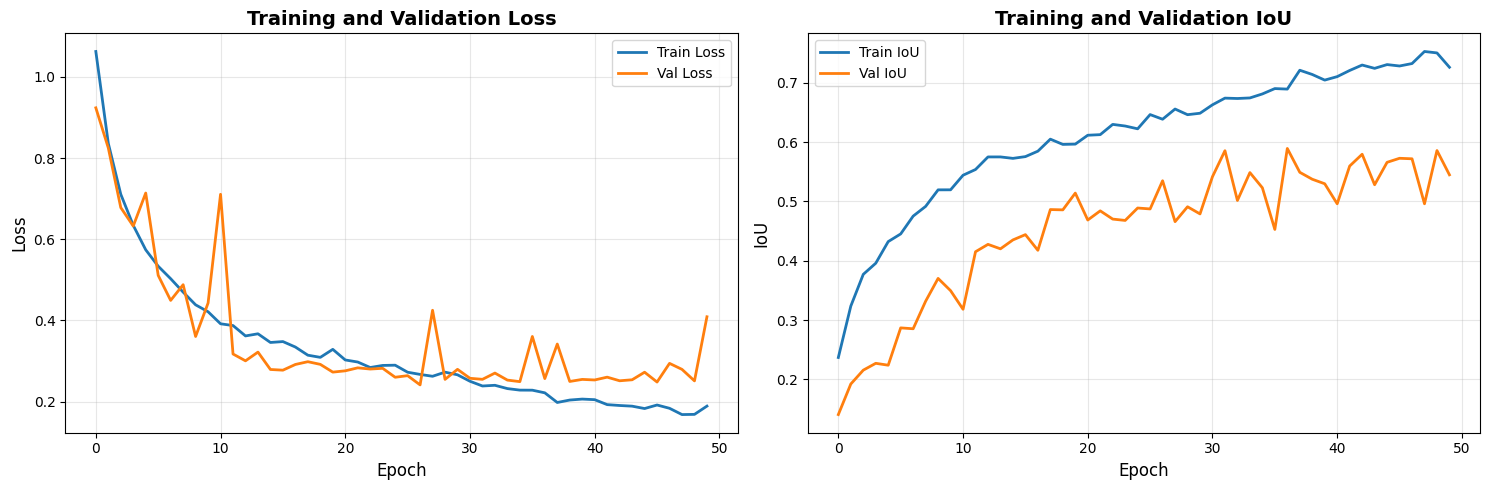

Training history saved to 'training_history.png'


In [74]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_losses, label='Train Loss', linewidth=2)
ax1.plot(val_losses, label='Val Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

ax2.plot(train_ious, label='Train IoU', linewidth=2)
ax2.plot(val_ious, label='Val IoU', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('IoU', fontsize=12)
ax2.set_title('Training and Validation IoU', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print("Training history saved to 'training_history.png'")

## 14. Load Best Model and Visualize Predictions

In [77]:
checkpoint = torch.load(Config.BEST_MODEL_PATH, map_location=Config.DEVICE, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']}")
print(f"Val IoU: {checkpoint['val_iou']:.4f}")
print(f"Val Dice: {checkpoint['val_dice']:.4f}")

Loaded best model from epoch 36
Val IoU: 0.5892
Val Dice: 0.2339


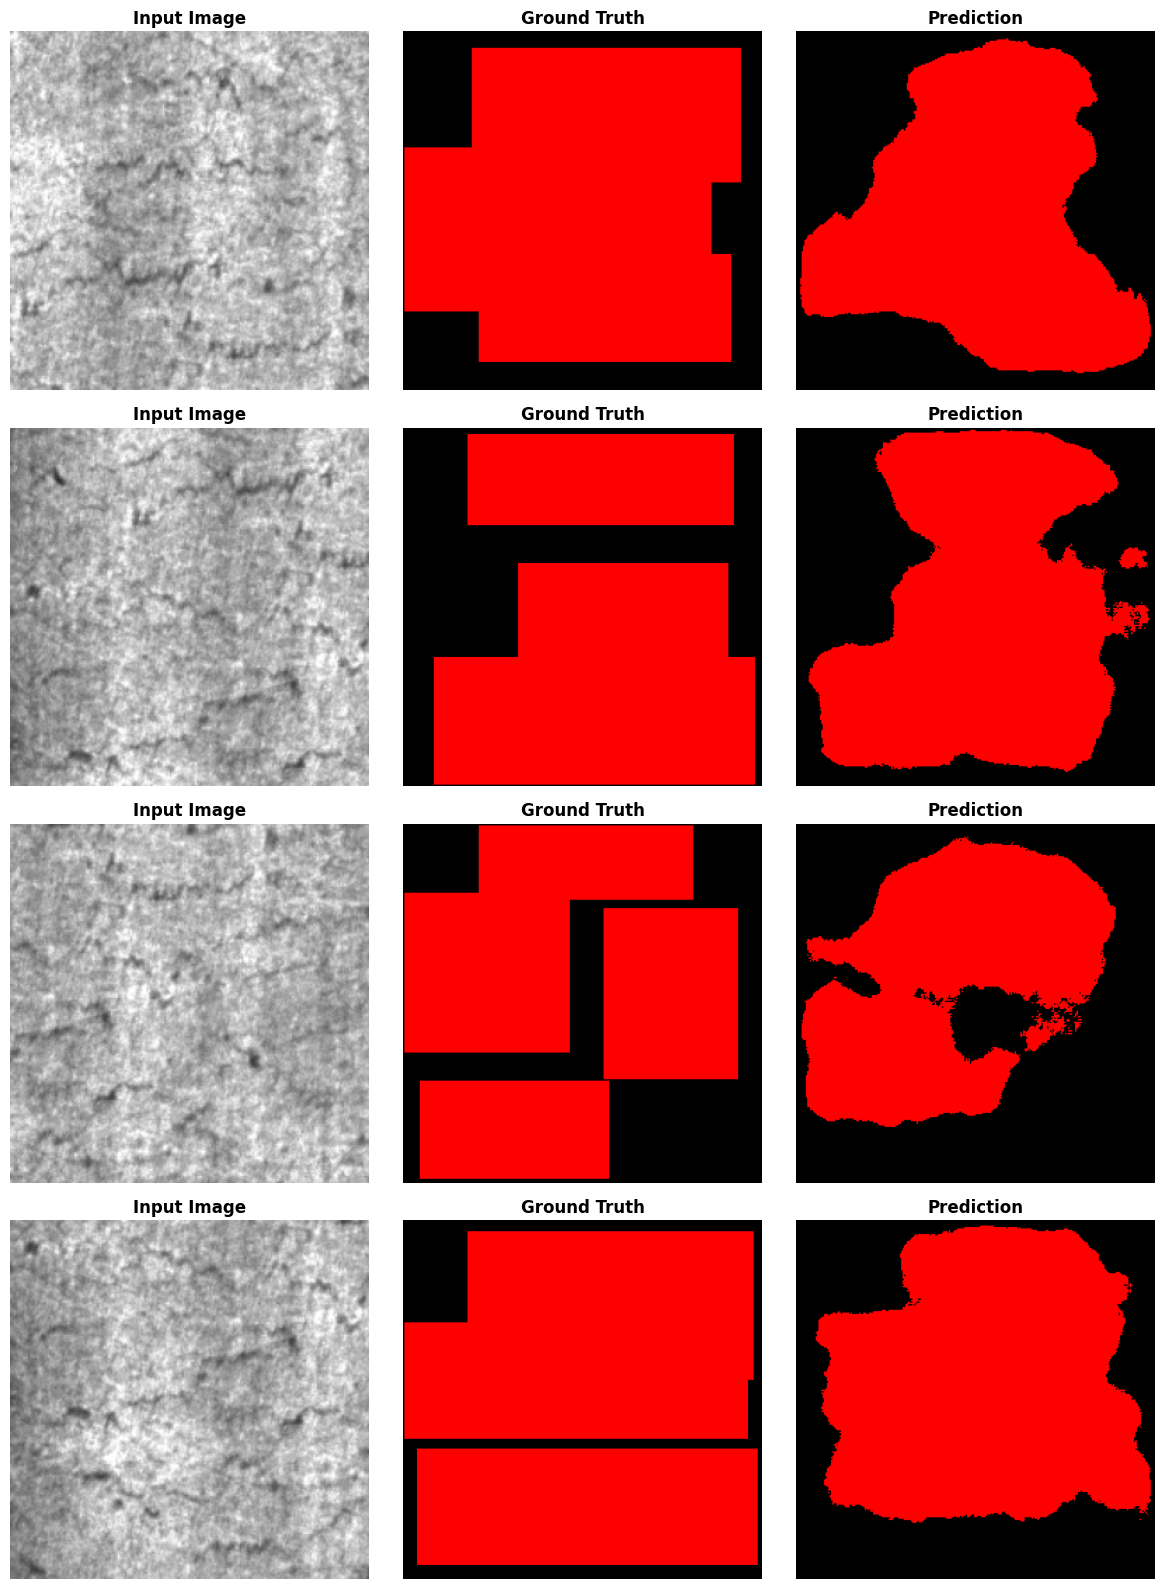

Sample predictions saved to 'predictions.png'


In [76]:
def mask_to_color(mask, num_classes=7):
    h, w = mask.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)

    for cls in range(num_classes):
        color_mask[mask == cls] = Config.CLASS_COLORS[cls]

    return color_mask


model.eval()
images, masks = next(iter(val_loader))
images = images.to(Config.DEVICE)
masks = masks.to(Config.DEVICE)

with torch.no_grad():
    outputs = model(images)
    predictions = torch.argmax(outputs, dim=1)

num_samples = min(4, len(images))
fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4*num_samples))

for i in range(num_samples):
    img = images[i].cpu().permute(1, 2, 0).numpy()
    axes[i, 0].imshow(img)
    axes[i, 0].set_title('Input Image', fontsize=12, fontweight='bold')
    axes[i, 0].axis('off')

    gt = masks[i].cpu().numpy()
    gt_color = mask_to_color(gt, Config.OUT_CHANNELS)
    axes[i, 1].imshow(gt_color)
    axes[i, 1].set_title('Ground Truth', fontsize=12, fontweight='bold')
    axes[i, 1].axis('off')

    pred = predictions[i].cpu().numpy()
    pred_color = mask_to_color(pred, Config.OUT_CHANNELS)
    axes[i, 2].imshow(pred_color)
    axes[i, 2].set_title('Prediction', fontsize=12, fontweight='bold')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.savefig('predictions.png', dpi=150, bbox_inches='tight')
plt.show()

print("Sample predictions saved to 'predictions.png'")

## 15. Class Legend

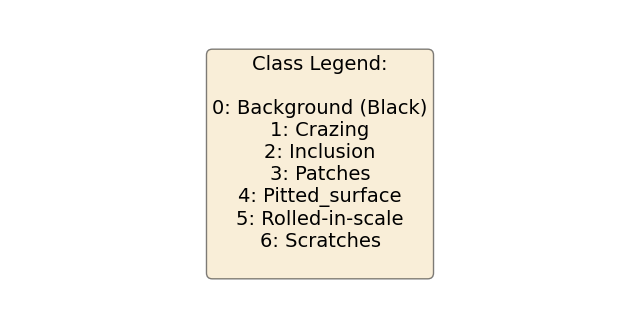


Defect Classes:
0: Background
1: crazing
2: inclusion
3: patches
4: pitted_surface
5: rolled-in-scale
6: scratches


In [78]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.axis('off')

legend_text = "Class Legend:\n\n"
legend_text += "0: Background (Black)\n"
for i, defect in enumerate(Config.DEFECT_CLASSES):
    color = np.array(Config.CLASS_COLORS[i+1]) / 255.0
    legend_text += f"{i+1}: {defect.capitalize()}\n"

ax.text(0.5, 0.5, legend_text, fontsize=14, ha='center', va='center',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.savefig('class_legend.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nDefect Classes:")
print("0: Background")
for i, defect in enumerate(Config.DEFECT_CLASSES):
    print(f"{i+1}: {defect}")

## 16. Inference Functions

In [87]:
def predict_single_image(model, image_path, device):
    model.eval()

    image = Image.open(image_path).convert('RGB')
    original_size = image.size

    image = image.resize((Config.IMAGE_SIZE, Config.IMAGE_SIZE), Image.BILINEAR)
    image_array = np.array(image, dtype=np.float32) / 255.0

    image_tensor = torch.from_numpy(image_array).permute(2, 0, 1).unsqueeze(0)
    image_tensor = image_tensor.to(device)

    with torch.no_grad():
        output = model(image_tensor)
        prediction = torch.argmax(output, dim=1)[0].cpu().numpy()

    prediction = cv2.resize(prediction.astype(np.uint8), original_size, interpolation=cv2.INTER_NEAREST)

    return prediction

### Debugging Code

In [80]:
xml_path = os.path.join(Config.TRAIN_ANN_DIR, 'crazing_1.xml')
defect_class = 'crazing'

mask = train_dataset.parse_xml_to_mask(xml_path, defect_class)

print(f"Mask returned: {mask is not None}")
if mask is not None:
    print(f"Mask shape: {mask.shape}")
    print(f"Non-zero pixels: {(mask > 0).sum()}")
    print(f"Unique values: {np.unique(mask)}")
else:
    print("Mask is None!")

Mask returned: True
Mask shape: (200, 200)
Non-zero pixels: 36672
Unique values: [0 1]


In [72]:
import xml.etree.ElementTree as ET

xml_path = os.path.join(Config.TRAIN_ANN_DIR, 'crazing_1.xml')
print(f"Testing XML: {xml_path}\n")

tree = ET.parse(xml_path)
root = tree.getroot()

size_elem = root.find('size')
if size_elem is not None:
    width = int(size_elem.find('width').text)
    height = int(size_elem.find('height').text)
    print(f"Image size from XML: {width}x{height}\n")

mask = np.zeros((height, width), dtype=np.uint8)
print(f"Created mask shape: {mask.shape}\n")

for obj in root.findall('.//object'):
    print("Found object!")
    bndbox = obj.find('bndbox')
    if bndbox is not None:
        print("  Found bndbox!")
        xmin_elem = bndbox.find('xmin')
        ymin_elem = bndbox.find('ymin')
        xmax_elem = bndbox.find('xmax')
        ymax_elem = bndbox.find('ymax')

        print(f"  xmin_elem: {xmin_elem}, text: {xmin_elem.text if xmin_elem is not None else 'None'}")
        print(f"  ymin_elem: {ymin_elem}, text: {ymin_elem.text if ymin_elem is not None else 'None'}")
        print(f"  xmax_elem: {xmax_elem}, text: {xmax_elem.text if xmax_elem is not None else 'None'}")
        print(f"  ymax_elem: {ymax_elem}, text: {ymax_elem.text if ymax_elem is not None else 'None'}")

        if all([xmin_elem is not None, ymin_elem is not None,
                xmax_elem is not None, ymax_elem is not None]):
            xmin = int(float(xmin_elem.text))
            ymin = int(float(ymin_elem.text))
            xmax = int(float(xmax_elem.text))
            ymax = int(float(ymax_elem.text))

            print(f"  Coordinates: ({xmin},{ymin}) to ({xmax},{ymax})")

            mask[ymin:ymax, xmin:xmax] = 1
            print(f"  Mask non-zero pixels after: {(mask > 0).sum()}")

print(f"\nFinal mask non-zero pixels: {(mask > 0).sum()}")
print(f"Final mask unique values: {np.unique(mask)}")

Testing XML: /kaggle/input/neu-surface-defect-database/NEU-DET/train/annotations/crazing_1.xml

Image size from XML: 200x200

Created mask shape: (200, 200)

Found object!
  Found bndbox!
  xmin_elem: <Element 'xmin' at 0x78ee6c0967f0>, text: 2
  ymin_elem: <Element 'ymin' at 0x78ee6c096750>, text: 2
  xmax_elem: <Element 'xmax' at 0x78ee6c0967a0>, text: 193
  ymax_elem: <Element 'ymax' at 0x78ee6c096c50>, text: 194
  Coordinates: (2,2) to (193,194)
  Mask non-zero pixels after: 36672

Final mask non-zero pixels: 36672
Final mask unique values: [0 1]
